# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [3]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

from plotly.figure_factory import create_table
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, precision_score, recall_score, classification_report
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, KBinsDiscretizer, StandardScaler, QuantileTransformer

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

import warnings

warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [5]:
df.head()

age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  
0          93.994          -36.4      4.857       5191.0  no  
1          93.994          -36.4      4.857       5191.0  no  
2          93.994          -36.4      4.857       5191.0  no  
3          93.994          -36.4      4.857       5191.0  no  
4          93.994          -36.4      4.857       5191.0  no  

[5 rows x 21 columns]

### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.

##### Input variables:
###### bank client data:
 1 - age (numeric)
 2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
 3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
 4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
 5 - default: has credit in default? (categorical: 'no','yes','unknown')
 6 - housing: has housing loan? (categorical: 'no','yes','unknown')
 7 - loan: has personal loan? (categorical: 'no','yes','unknown')
##### 
###### related with the last contact of the current campaign:
 8 - contact: contact communication type (categorical: 'cellular','telephone')
 9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
 10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
 11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
##### 
###### other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
#####
###### social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)
#####
###### Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')




In [6]:
# raname the dot separation at feature naming
df.rename(columns={'emp.var.rate':'emp_var_rate', 'cons.price.idx':'cons_price_idx', 'cons.conf.idx':'cons_conf_idx','nr.employed':'nr_employed', 'euribor3m':'euribor_3m'}, inplace=True)

<Axes: >

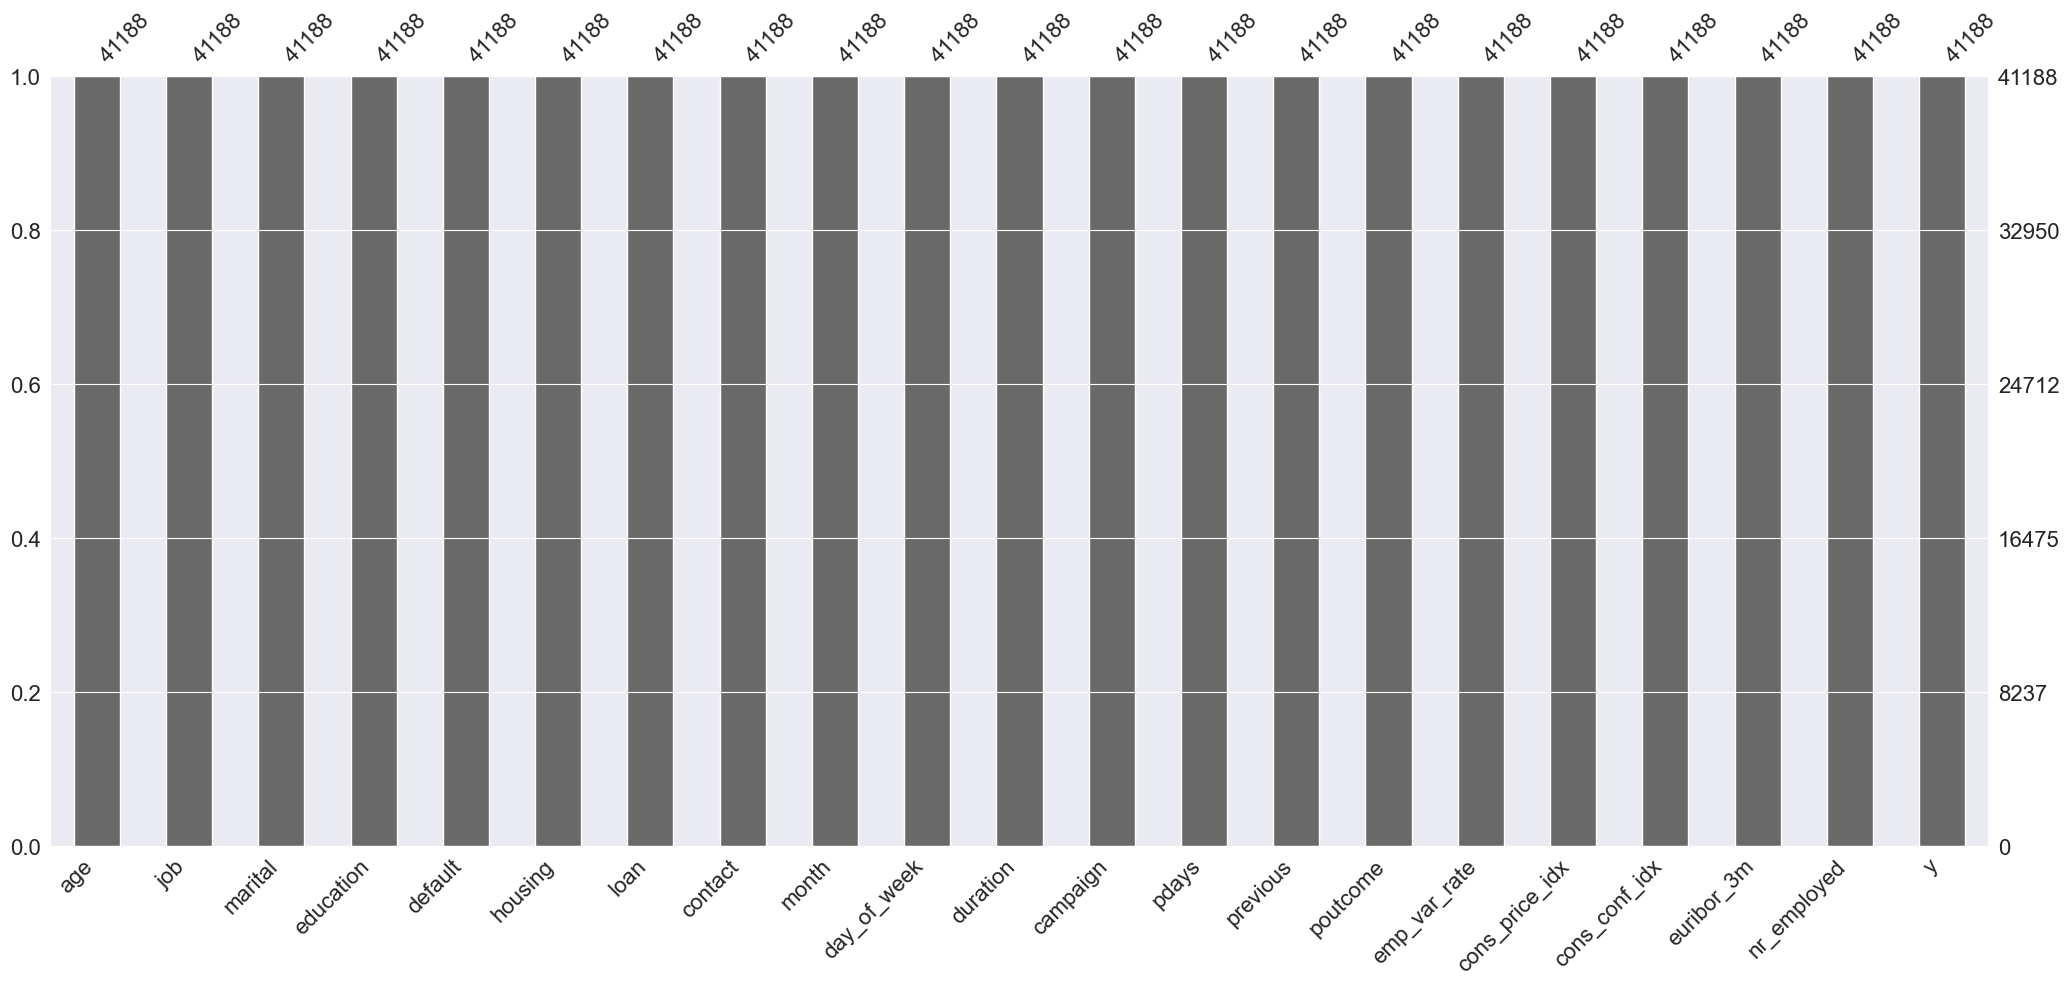

In [7]:
msno.bar(df)

###### All features are the same size of 41188, so no data is missing.

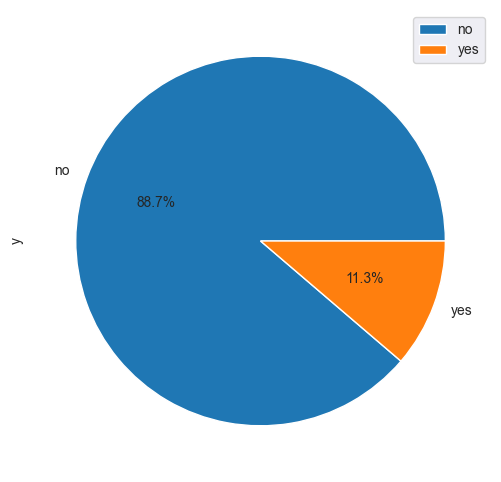

In [8]:
df['y'].value_counts().plot.pie(legend= True, figsize = (16,6), autopct = '%1.1f%%');

###### the above target plots shows, the target imbalanced classes 'no' = 88.7% and 'yes' = 11.3% 

In [9]:
print(f'Are there any duplicates : {df.duplicated().any()} and size: {df.shape[0]}')

Are there any duplicates : True and size: 41188


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp_var_rate    41188 non-null  float64
 16  cons_price_idx  41188 non-null  float64
 17  cons_conf_idx   41188 non-null 

###### No data is missing, but there are duplicates, those 11 object features need to be converted to numerical data (encoded)

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

###### The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. 

###### The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y).

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features (columns 1 - 7), prepare the features and target column for modeling with appropriate encoding and transformations.

In [11]:
df.drop('duration', axis=1, inplace=True)

In [12]:
# check for duplicates, and remove any
if df.duplicated().any():
    print(f'before dropping the duplicates, data size: {df.shape[0]}')
    df.drop_duplicates(inplace=True)

    # reset indices after dropping rows
    df=df.reset_index(drop=True)

    print(f'after dropping the duplicates  data size: {df.shape[0]}')
else:
    print(f'there are no any duplicates: data size: {df.shape[0]}')

before dropping the duplicates, data size: 41188
after dropping the duplicates  data size: 39404


In [13]:
df.head()

age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  campaign  pdays  previous     poutcome  emp_var_rate  \
0   may         mon         1    999         0  nonexistent           1.1   
1   may         mon         1    999         0  nonexistent           1.1   
2   may         mon         1    999         0  nonexistent           1.1   
3   may         mon         1    999         0  nonexistent           1.1   
4   may         mon         1    999         0  nonexistent           1.1   

   cons_price_idx  cons_conf_idx  euribor_3m  nr_employed   y  
0          93.994          -36.4       4.857       5191.0  no  
1          93.994          -36.4       4.857       5191.0  no  
2          93.994          -36.4       4.857       5191.0  no  
3          93.994          -36.4       4.857       5191.0  no  
4          93.994          -36.4       4.857       5191.0  no

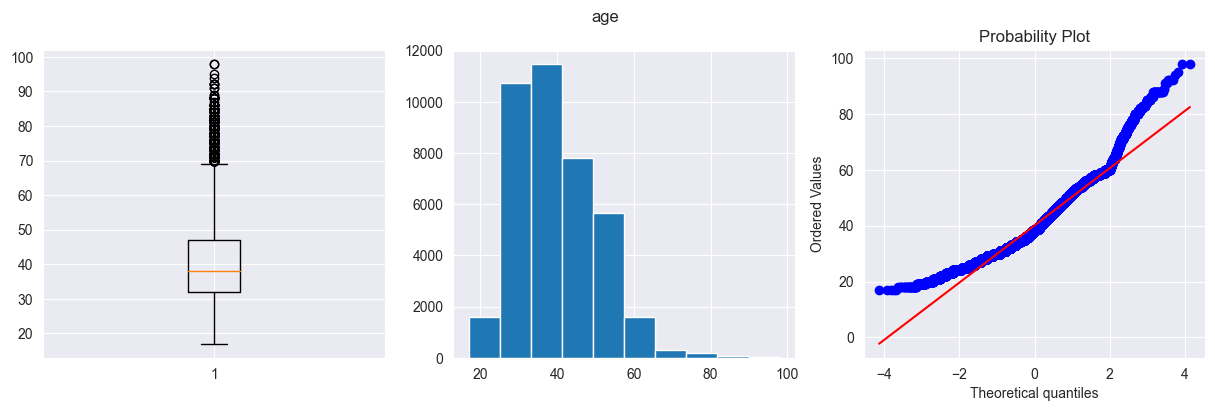

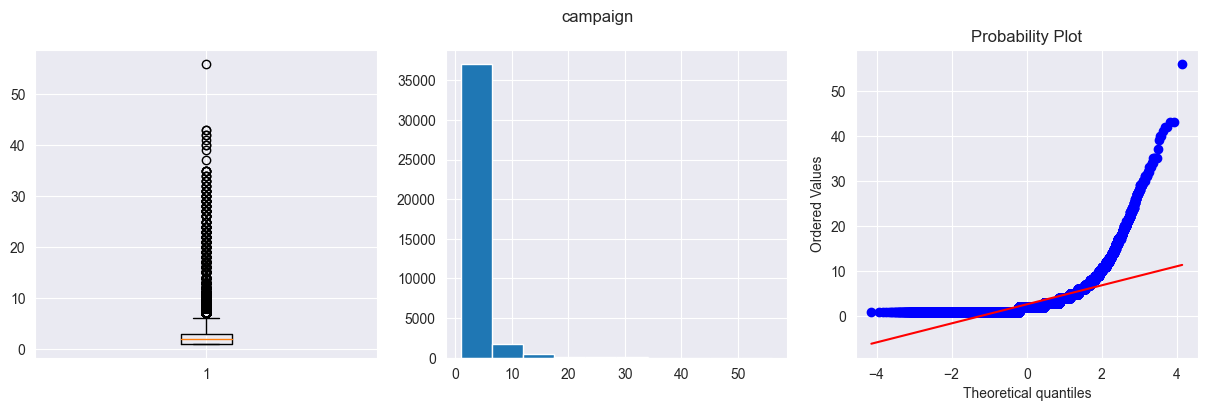

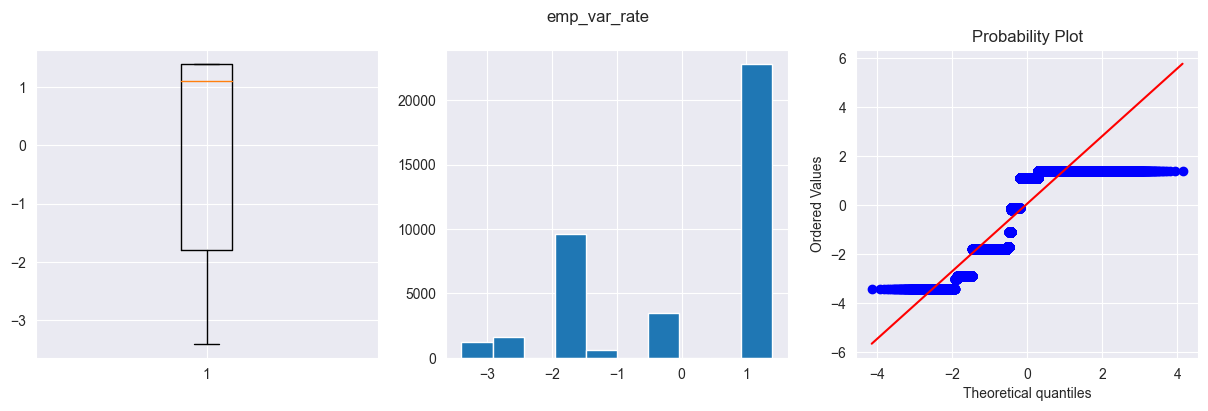

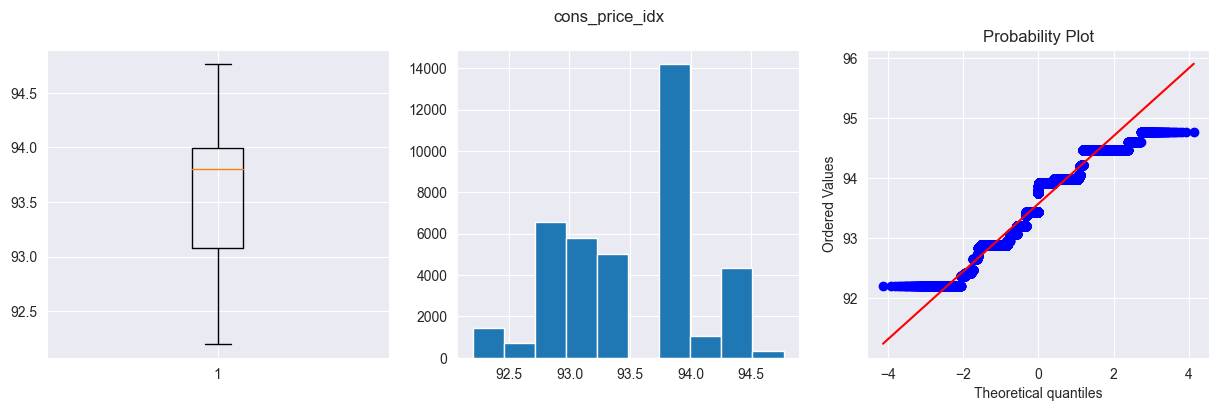

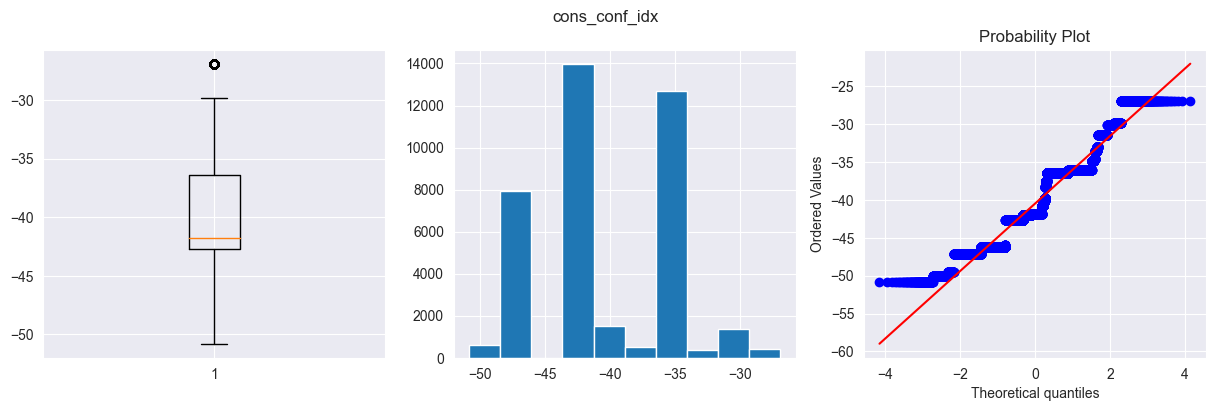

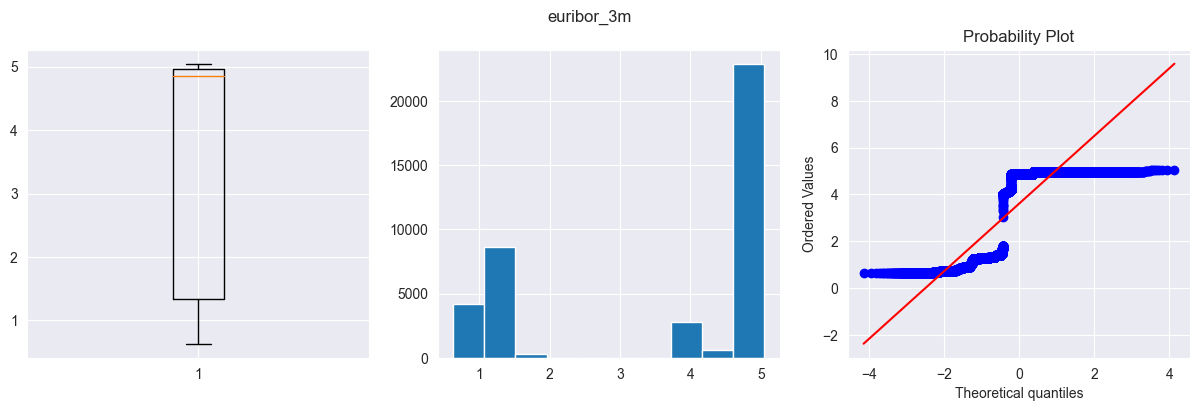

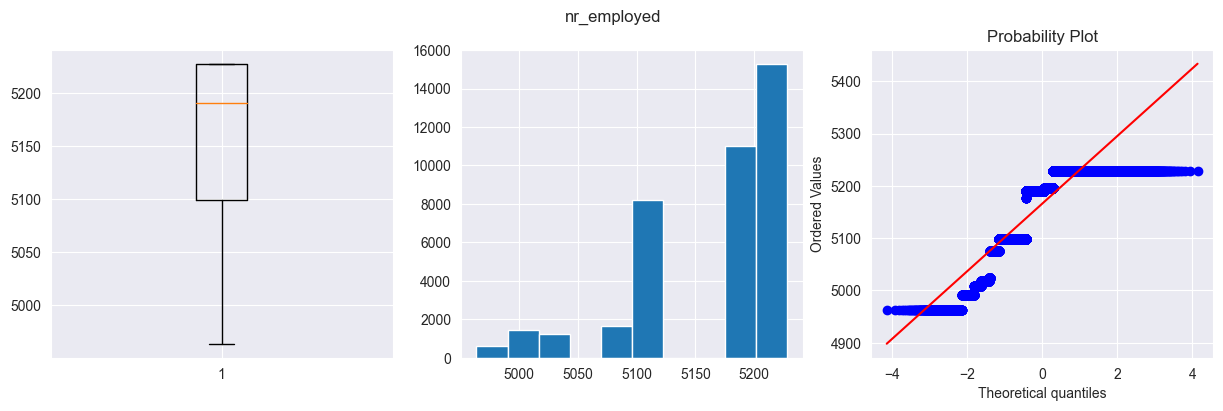

In [14]:
#checking for any outliers, if any
cols = ['age', 'campaign', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m','nr_employed']

for col in cols:
    fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(15, 4))
    fig.suptitle(col)
    axes[0].boxplot(df[col])
    axes[1].hist(df[col])
    stats.probplot(df[col], dist='norm', plot=axes[2])
    plt.show()

##### The emp_var_rate, cons_price_idx, euribor_3m and nr_employed have no outliers.

Before Shape: (39404, 20)
After Shape: (39403, 20)


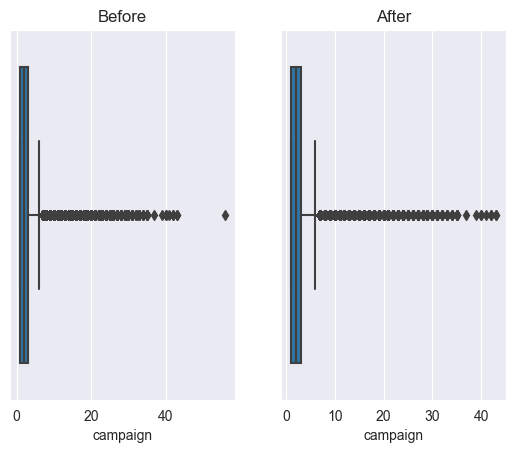

In [15]:
# remove outlier of campaign
fig, axes = plt.subplots(1,2)

df2 = df

col='campaign'

print("Before Shape:",df2.shape)
axes[0].title.set_text("Before")
sns.boxplot(df2[col],orient='v',ax=axes[0])

# Removing campaign above 50 
df2 = df2[ (df2[col]<50)]
print("After Shape:",df2.shape)

axes[1].title.set_text("After")
sns.boxplot(df2[col],orient='v',ax=axes[1])
df=df2;
plt.show()

# reset indices after dropping rows
df=df.reset_index(drop=True)

##### In the campaign we can identify the outliers and let's remove them

Before Shape: (39403, 20)
After Shape: (38967, 20)


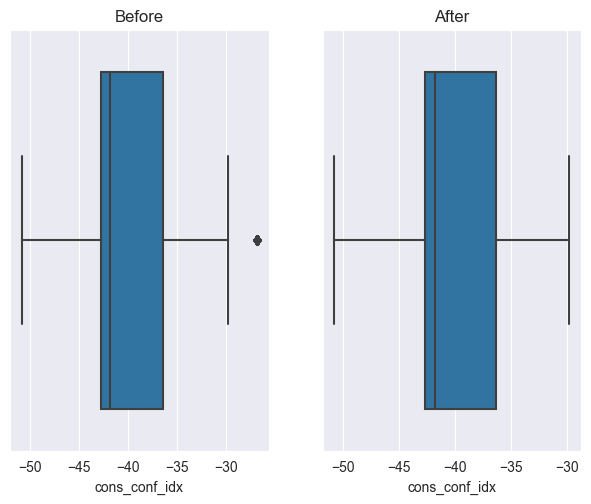

In [16]:
# remove outlier of cons_price_idx

fig, axes = plt.subplots(1,2)
plt.tight_layout()

df2 = df

col='cons_conf_idx'

print("Before Shape:",df2.shape)
axes[0].title.set_text("Before")
sns.boxplot(df2[col],orient='v',ax=axes[0])

# Removing cons_price_idx above -28 
df2 = df2[ (df2[col]<-28)]
print("After Shape:",df2.shape)

axes[1].title.set_text("After")
sns.boxplot(df2[col],orient='v',ax=axes[1])
df=df2;
plt.show()

# reset indices after dropping rows
df=df.reset_index(drop=True)

##### Also, in the cons_conf_idx we can identify the outliers and let's remove them.

In [17]:
# We need to transform all categorical features with Encoder
df_label = df.select_dtypes(include = np.object)
df_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38967 entries, 0 to 38966
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   job          38967 non-null  object
 1   marital      38967 non-null  object
 2   education    38967 non-null  object
 3   default      38967 non-null  object
 4   housing      38967 non-null  object
 5   loan         38967 non-null  object
 6   contact      38967 non-null  object
 7   month        38967 non-null  object
 8   day_of_week  38967 non-null  object
 9   poutcome     38967 non-null  object
 10  y            38967 non-null  object
dtypes: object(11)
memory usage: 3.3+ MB


In [18]:
df_label.nunique()

job            12
marital         4
education       8
default         3
housing         3
loan            3
contact         2
month          10
day_of_week     5
poutcome        3
y               2
dtype: int64

##### The features job, marital, education, default, housing, loan, month, day_of_week, and poutcome are used the one-hot encoding since they have more than 2 unique values.

In [19]:
df['contact'] = df['contact'].astype('category').cat.codes

In [20]:
encoder=OneHotEncoder(sparse=False)

columns = ['job','marital','education','default','housing','loan','month','day_of_week','poutcome']

df_encoded = pd.DataFrame (encoder.fit_transform(df[columns]))

df_encoded.columns = encoder.get_feature_names_out(columns)
df.drop(columns ,axis=1, inplace=True)
df= pd.concat([df, df_encoded ], axis=1)

In [21]:
contact_data = df.drop(['contact'] ,axis=1, inplace=True)
df= pd.concat([df, contact_data ], axis=1)

cont_cols =  ['age', 'campaign', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed']


In [22]:
df.head(5)

age  campaign  pdays  previous  emp_var_rate  cons_price_idx  \
0   56         1    999         0           1.1          93.994   
1   57         1    999         0           1.1          93.994   
2   37         1    999         0           1.1          93.994   
3   40         1    999         0           1.1          93.994   
4   56         1    999         0           1.1          93.994   

   cons_conf_idx  euribor_3m  nr_employed   y  ...  month_oct  month_sep  \
0          -36.4       4.857       5191.0  no  ...        0.0        0.0   
1          -36.4       4.857       5191.0  no  ...        0.0        0.0   
2          -36.4       4.857       5191.0  no  ...        0.0        0.0   
3          -36.4       4.857       5191.0  no  ...        0.0        0.0   
4          -36.4       4.857       5191.0  no  ...        0.0        0.0   

   day_of_week_fri  day_of_week_mon  day_of_week_thu  day_of_week_tue  \
0              0.0              1.0              0.0              0.0   
1              0.0              1.0              0.0              0.0   
2              0.0              1.0              0.0              0.0   
3              0.0              1.0              0.0              0.0   
4              0.0              1.0              0.0              0.0   

   day_of_week_wed  poutcome_failure  poutcome_nonexistent  poutcome_success  
0              0.0               0.0                   1.0               0.0  
1              0.0               0.0                   1.0               0.0  
2              0.0               0.0                   1.0               0.0  
3              0.0               0.0                   1.0               0.0  
4              0.0               0.0                   1.0               0.0  

[5 rows x 61 columns]

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'campaign'}>,
        <Axes: title={'center': 'pdays'}>],
       [<Axes: title={'center': 'previous'}>,
        <Axes: title={'center': 'emp_var_rate'}>,
        <Axes: title={'center': 'cons_price_idx'}>],
       [<Axes: title={'center': 'cons_conf_idx'}>,
        <Axes: title={'center': 'euribor_3m'}>,
        <Axes: title={'center': 'nr_employed'}>]], dtype=object)

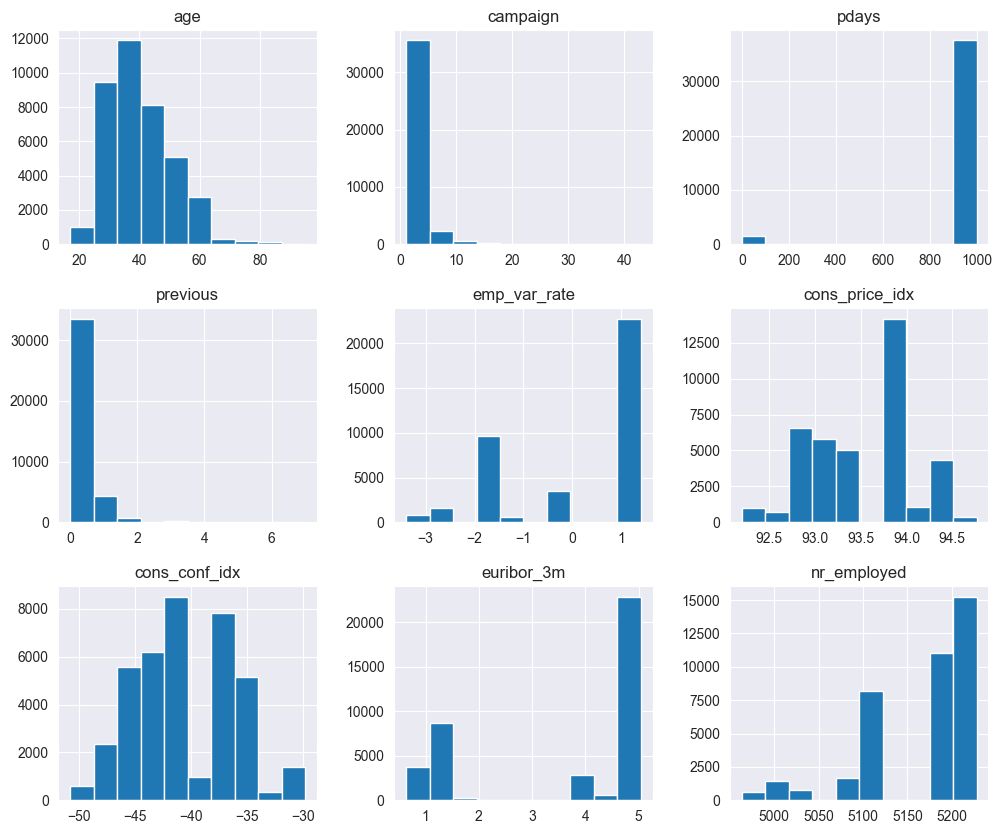

In [23]:
df[cont_cols].hist(figsize = (12,10))

##### age, campaign and previous are right skewed and nr_employed is left skewed

In [24]:
#Do the logarithm trasnformations for required features
logarithm_transformer = FunctionTransformer(np.log1p, validate=True)

# apply the transformation to your data
columns = ['age', 'campaign', 'previous']
to_right_skewed = logarithm_transformer.transform(df[columns])

df['age'] = to_right_skewed[:, 0]
df['campaign'] = to_right_skewed[:, 1]
df['previous'] = to_right_skewed[:, 2]

##### reduce the skewness and come to normal distribution form, the age, campaign and previous are applied log transformation.

In [25]:
columns = ['nr_employed']
exp_transformer = FunctionTransformer(lambda x:x**2, validate=True) # FunctionTransformer(np.exp, validate=True) #
to_left_skewed = exp_transformer.transform(df[columns])
df['nr_employed'] = to_left_skewed[:, 0]

##### nr_employed is applied x² transformation.

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'campaign'}>,
        <Axes: title={'center': 'pdays'}>],
       [<Axes: title={'center': 'previous'}>,
        <Axes: title={'center': 'emp_var_rate'}>,
        <Axes: title={'center': 'cons_price_idx'}>],
       [<Axes: title={'center': 'cons_conf_idx'}>,
        <Axes: title={'center': 'euribor_3m'}>,
        <Axes: title={'center': 'nr_employed'}>]], dtype=object)

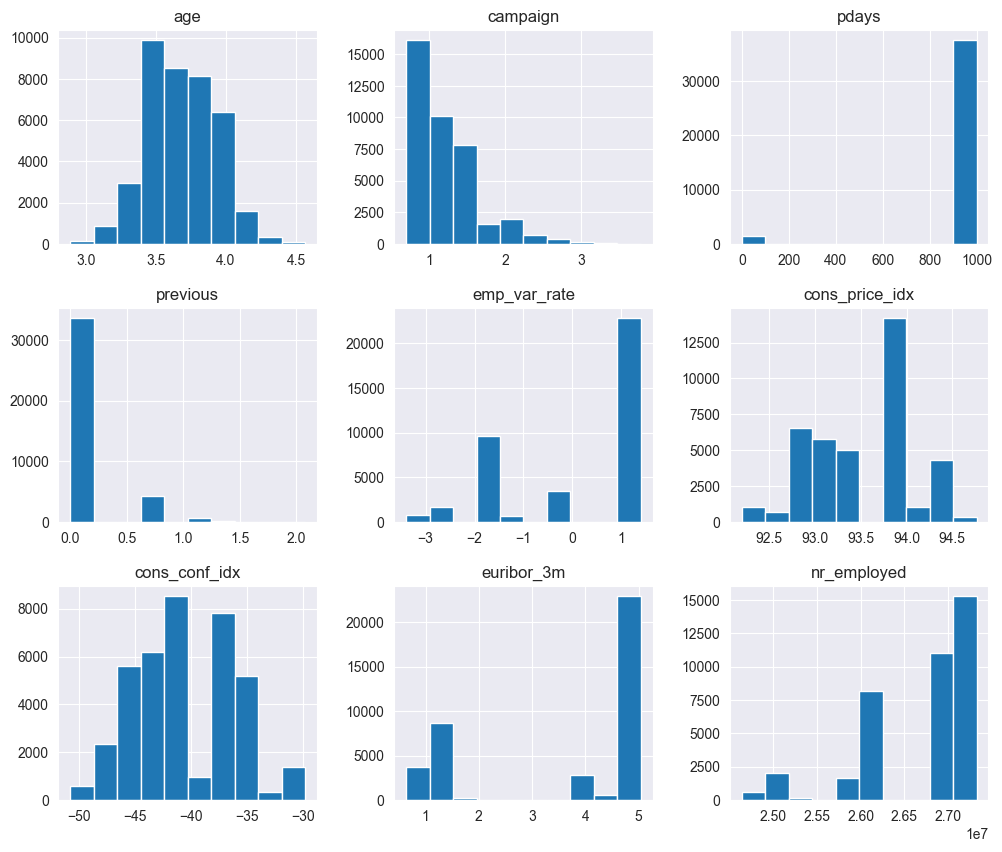

In [26]:
df[cont_cols].hist(figsize = (12,10))

In [27]:
data = pd.DataFrame(df, columns=['age'])

# fit the scaler to the  data
discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='kmeans')
discretizer.fit(data)
_discretize = discretizer.transform(data)
x = pd.DataFrame(_discretize, columns=['age'])
df['age'] = x['age']

##### Set 10 bins for the feature age

In [28]:
df2 = df

# Removing Categorical Features before the feature scaling
columns = df.columns

# Continuous col
columns_cont = np.delete(columns,np.s_[9:])
# Categorical col
columns_categorical = np.delete(columns,np.s_[0:9])

# except age since it is discretized
except_age_cont = np.delete(columns_cont, [0])


# Applying Standardization 
# Init StandardScaler
scaler = StandardScaler()

#Transformation of training dataset features
Except = pd.DataFrame(df, columns = except_age_cont)
scaler.fit(Except)

df = pd.DataFrame(scaler.transform(Except), columns = except_age_cont).join(df[columns_categorical])
df = df.join(df2['age'])

##### continuous data are added Standardization (except the age, since it is discretized)

In [29]:
# Get age in last column to first column
cols = list(df.columns)
cols = [cols[-1]] + cols[:-1]  #make last column first
df=df[cols]

##### Get age in last column to first column

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'campaign'}>,
        <Axes: title={'center': 'pdays'}>],
       [<Axes: title={'center': 'previous'}>,
        <Axes: title={'center': 'emp_var_rate'}>,
        <Axes: title={'center': 'cons_price_idx'}>],
       [<Axes: title={'center': 'cons_conf_idx'}>,
        <Axes: title={'center': 'euribor_3m'}>,
        <Axes: title={'center': 'nr_employed'}>]], dtype=object)

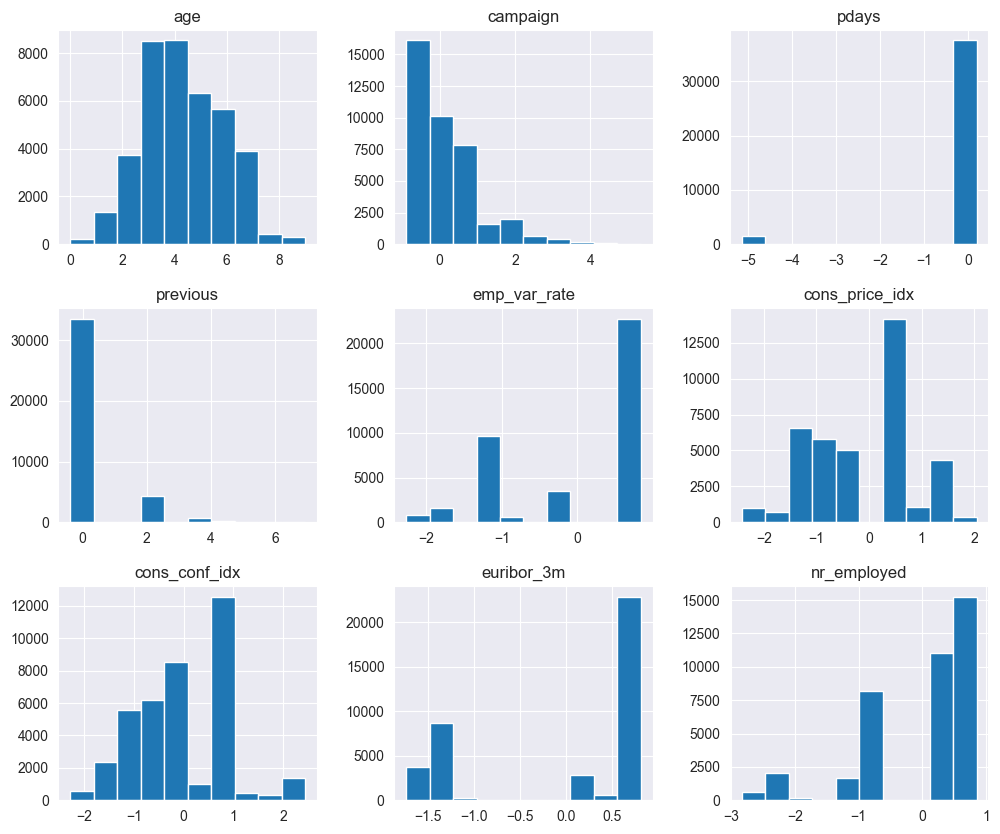

In [30]:
df[columns_cont].hist(figsize = (12,10))

<Figure size 1600x1600 with 0 Axes>

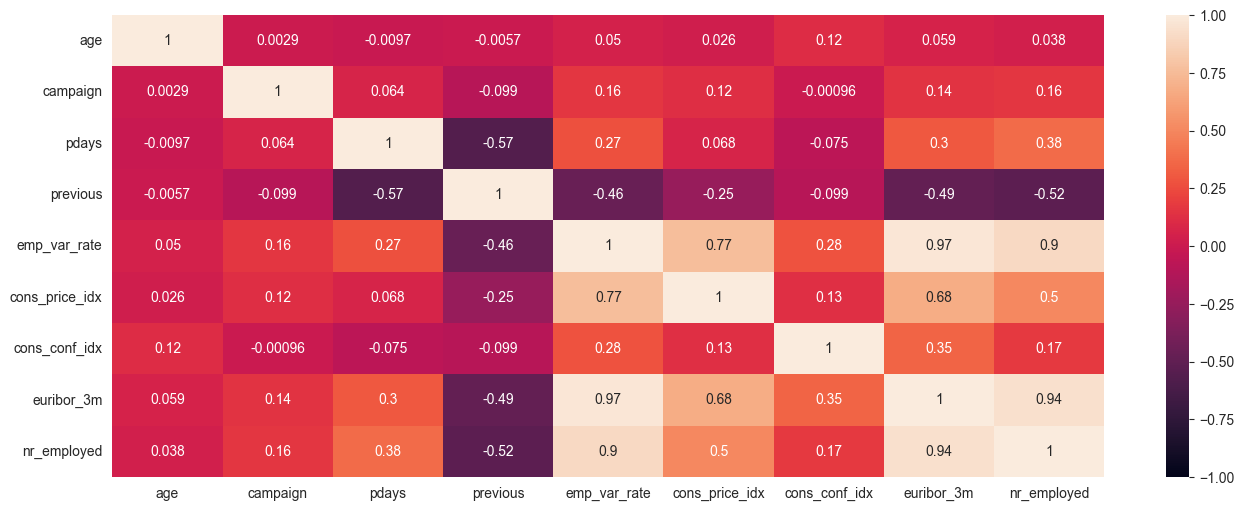

In [31]:
df_for_feature_eng = df[columns_cont]
df_for_feature_eng= df_for_feature_eng.join(df['y'])
plt.figure(figsize=(16, 16))
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df_for_feature_eng.corr(), vmin=-1, vmax=1, annot=True)
plt.show()

##### decide to to keep nr_employed and drop the euribor_3m, emp_var_rate and emp_pricce_idx since they are depended each other.

In [32]:
df.drop('emp_var_rate', axis=1, inplace=True)
df.drop('cons_price_idx', axis=1, inplace=True)
df.drop('euribor_3m', axis=1, inplace=True)

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [33]:
# set apparent temperature as target
columns_value = df.columns
index = np.argwhere(columns_value == 'y')
columns_value_new = np.delete(columns_value, index)


data = pd.DataFrame(df, columns=columns_value_new)

# target as Y
selected_columns = ['y']
y_true = df[selected_columns].copy()

# X as indipendent 
X = data

X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=0.33, random_state=42)
smt = SMOTE(random_state = 101)
X_train_smote, y_train_smote = smt.fit_resample(X_train, y_train)

print(X_train_smote.shape, y_train_smote.shape)
print(X_test.shape, y_test.shape)

(46338, 57) (46338, 1)
(12860, 57) (12860, 1)


###### when split the dataset, add SMOTE due to the y class imbalance

In [34]:
X_train.describe()

age      campaign         pdays      previous  cons_conf_idx  \
count  26107.000000  26107.000000  26107.000000  26107.000000   26107.000000   
mean       4.300609      0.006287      0.006707     -0.007261      -0.006131   
std        1.715415      1.005191      0.983428      0.992759       0.998476   
min        0.000000     -0.887760     -5.139117     -0.383443      -2.285353   
25%        3.000000     -0.887760      0.195816     -0.383443      -0.461237   
50%        4.000000     -0.071207      0.195816     -0.383443      -0.258557   
75%        6.000000      0.508148      0.195816     -0.383443       0.957520   
max        9.000000      5.337196      0.195816      6.922557       2.443836   

        nr_employed    job_admin.  job_blue-collar  job_entrepreneur  \
count  26107.000000  26107.000000     26107.000000      26107.000000   
mean       0.001481      0.248937         0.224691          0.035776   
std        1.000221      0.432406         0.417386          0.185734   
min       -2.827284      0.000000         0.000000          0.000000   
25%       -0.967088      0.000000         0.000000          0.000000   
50%        0.323060      0.000000         0.000000          0.000000   
75%        0.850423      0.000000         0.000000          0.000000   
max        0.850423      1.000000         1.000000          1.000000   

       job_housemaid  ...     month_oct     month_sep  day_of_week_fri  \
count   26107.000000  ...  26107.000000  26107.000000     26107.000000   
mean        0.026698  ...      0.007201      0.015245         0.190562   
std         0.161202  ...      0.084555      0.122528         0.392752   
min         0.000000  ...      0.000000      0.000000         0.000000   
25%         0.000000  ...      0.000000      0.000000         0.000000   
50%         0.000000  ...      0.000000      0.000000         0.000000   
75%         0.000000  ...      0.000000      0.000000         0.000000   
max         1.000000  ...      1.000000      1.000000         1.000000   

       day_of_week_mon  day_of_week_thu  day_of_week_tue  day_of_week_wed  \
count     26107.000000     26107.000000     26107.000000     26107.000000   
mean          0.208412         0.208335         0.195465         0.197227   
std           0.406180         0.406125         0.396566         0.397913   
min           0.000000         0.000000         0.000000         0.000000   
25%           0.000000         0.000000         0.000000         0.000000   
50%           0.000000         0.000000         0.000000         0.000000   
75%           0.000000         0.000000         0.000000         0.000000   
max           1.000000         1.000000         1.000000         1.000000   

       poutcome_failure  poutcome_nonexistent  poutcome_success  
count      26107.000000          26107.000000      26107.000000  
mean           0.102884              0.864826          0.032290  
std            0.303814              0.341916          0.176773  
min            0.000000              0.000000          0.000000  
25%            0.000000              1.000000          0.000000  
50%            0.000000              1.000000          0.000000  
75%            0.000000              1.000000          0.000000  
max            1.000000              1.000000          1.000000  

[8 rows x 57 columns]

In [35]:
# Number of Features in the dataset
df.drop('y', axis=1).shape[1]

57

###### With the categorical features there are 57 features to predict the target. However, with the increasing the features of the model, it becomes more complex and leads to overfit. 
###### PCA is used commonly as Feature extraction technique to reduce the dimensions of the dataset.

In [36]:
# see explained variance ratios
pca = PCA()
pca.fit(X_train)

PCA()

In [37]:
pd.DataFrame(pca.explained_variance_ratio_).head(25)

0
0   0.234528
1   0.162466
2   0.082764
3   0.076024
4   0.046650
5   0.037252
6   0.036381
7   0.033117
8   0.023987
9   0.021162
10  0.020689
11  0.019733
12  0.017558
13  0.016045
14  0.015849
15  0.014972
16  0.014893
17  0.014678
18  0.011226
19  0.010761
20  0.010227
21  0.009025
22  0.008357
23  0.007689
24  0.006325

In [38]:
# The training model takes 25 components contain 95% of the information
pca.explained_variance_ratio_[:23].sum()

0.9383436489291307

###### By using the attribute explained_variance_ratio_ the variance first principal components contain up to 95% are taken to the model training.

In [39]:
pca = PCA(n_components = 23)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

##### The Baseline Model is using normalized data with mean = 0 and std=1, and the benchmark for the scores and runtime will be the max & mean of the models' accuracy score and performance

In [40]:
# the QuantileTransformer is returning data distribution with mean = 0 and std = 1
pipelines = {
    'lr': Pipeline([('scaler', QuantileTransformer(output_distribution='normal')), ('classifier', LogisticRegression())]),
}

In [41]:
scores = {}
y_preds = {}
for model_name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train.values.ravel())
    y_preds[model_name] = pipeline.predict(X_test)
    score = cross_val_score(pipeline, X_train, y_train.values.ravel(), cv=5, scoring='accuracy').mean()
    score_time = np.mean(cross_validate(pipeline, X_train, y_train.values.ravel())['score_time'])
    scores[model_name] = {'score': score, 'score_time': score_time}
    print(f"Baseline model score: with accuracy score {score:.4f} and score time {score_time:.4f}")

Baseline model score: with accuracy score 0.8977 and score time 0.0323


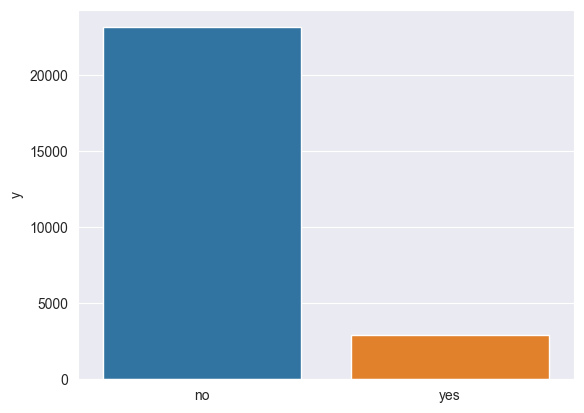

<Figure size 800x800 with 0 Axes>

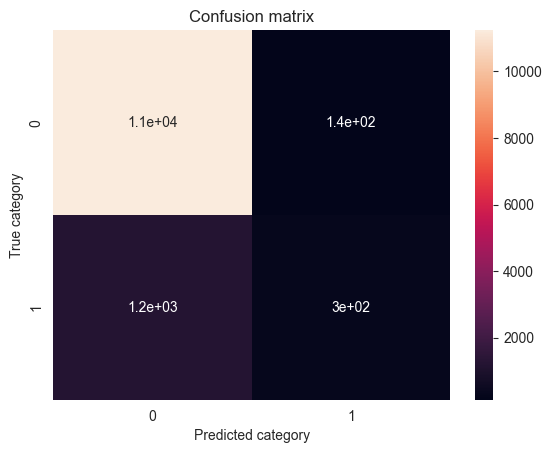

In [42]:
y_pred_bm = y_preds['lr']
sns.barplot(x=y_train['y'].value_counts().index, y=y_train['y'].value_counts())
cm = confusion_matrix(y_test, y_pred_bm)
plt.figure(figsize=(8, 8))
fig, ax = plt.subplots(1)
ax = sns.heatmap(cm, ax=ax, annot=True)  #normalize='all'
plt.title('Confusion matrix')
plt.ylabel('True category')
plt.xlabel('Predicted category')
plt.show()

In [43]:
print("Precision : ", precision_score(y_test, y_pred_bm, pos_label="no"))
print("Recall : ", recall_score(y_test, y_pred_bm, pos_label="no"))

Precision :  0.9046200901481004
Recall :  0.9878702645688671


In [44]:
print(classification_report(y_test, y_pred_bm))

              precision    recall  f1-score   support

          no       0.90      0.99      0.94     11377
         yes       0.68      0.20      0.31      1483

    accuracy                           0.90     12860
   macro avg       0.79      0.59      0.63     12860
weighted avg       0.88      0.90      0.87     12860


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [45]:
# The Simple Logistic Model uses dataset, which has been transformed with PCA Feature extraction technique
sc = StandardScaler()
X_train_pca_scaled = sc.fit_transform(X_train_pca)
X_test_pca_scaled = sc.transform(X_test_pca)
lgr_simp = LogisticRegression()

lgr_simp.fit(X_train_pca_scaled, y_train.values.ravel())

LogisticRegression()

In [46]:
y_pred_scaled = lgr_simp.predict(X_test_pca_scaled)

<Axes: ylabel='y'>

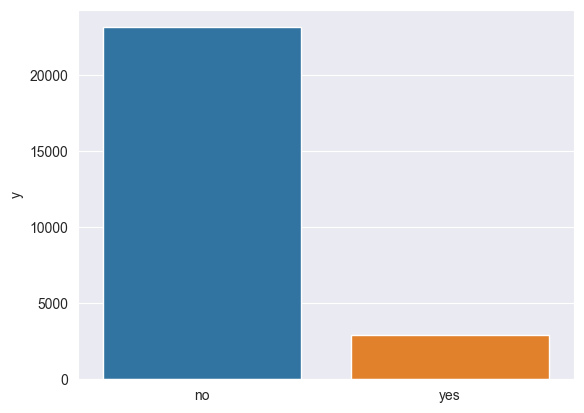

In [47]:
sns.barplot(x=y_train['y'].value_counts().index, y=y_train['y'].value_counts())

<Figure size 800x800 with 0 Axes>

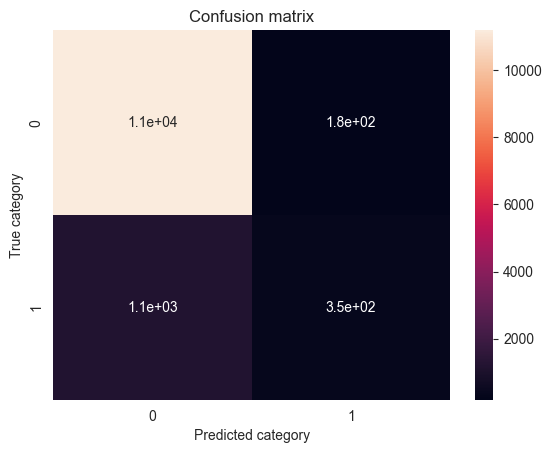

In [48]:
cm = confusion_matrix(y_test, y_pred_scaled)
plt.figure(figsize = (8,8))
fig, ax = plt.subplots(1)
ax = sns.heatmap(cm, ax=ax, annot=True) #normalize='all'
plt.title('Confusion matrix')
plt.ylabel('True category')
plt.xlabel('Predicted category')
plt.show()

In [49]:
print("Precision : ", precision_score(y_test, y_pred_scaled, pos_label="no"))
print("Recall : ", recall_score(y_test, y_pred_scaled, pos_label="no"))

Precision :  0.9081028469462243
Recall :  0.9840907093258329


In [50]:
print(classification_report(y_test, y_pred_scaled))

              precision    recall  f1-score   support

          no       0.91      0.98      0.94     11377
         yes       0.66      0.24      0.35      1483

    accuracy                           0.90     12860
   macro avg       0.78      0.61      0.65     12860
weighted avg       0.88      0.90      0.88     12860


###### Precision score of the model is 0.9081 which slightly better than the baseline model of 0.9044, but the Recall score of the model is slightly lower to the baseline model.

### Problem 9: Score the Model

What is the accuracy of your model?

In [51]:
print(f'the {lgr_simp.__class__.__name__} Model accuracy score: {np.mean(cross_val_score(lgr_simp, X_train_pca, y_train.values.ravel(), scoring="accuracy"))}')
print(f'the {lgr_simp.__class__.__name__} Model score time: {np.mean(cross_validate(lgr_simp, X_train_pca, y_train, scoring="accuracy", return_train_score=True)["score_time"])}')

the LogisticRegression Model accuracy score: 0.897230713457151
the LogisticRegression Model score time: 0.007099342346191406


###### The simple model has slightly lower accuracy score 0f 0.8972 to Baseline model of 0.8976, but it has better score time

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [52]:
report_data ={'Model' : ['Logistic Regression', 'Decision Tree', 'KNN', 'SVC'], 'Train Time':[], 'Train Accuracy' : [], 'Test Accuracy' : [], }
pipelines = {
    'lr': Pipeline([('scaler', StandardScaler()), ('classifier', LogisticRegression())]),
    'knn': Pipeline([('scaler', StandardScaler()), ('classifier', KNeighborsClassifier())]),
    'dt': Pipeline([('scaler', StandardScaler()), ('classifier', DecisionTreeClassifier())]),
    'svm': Pipeline([('scaler', StandardScaler()), ('classifier', SVC())]),
}

In [53]:
scores = {}
y_preds = {}
for model_name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train.values.ravel())
    scores_val = cross_validate(pipeline, X_train_pca, y_train, scoring="accuracy", return_train_score=True)
    train_score_pipe = np.mean(scores_val['train_score'])
    test_score_pipe = np.mean(scores_val['test_score'])
    fit_time_pipe = np.mean(scores_val['fit_time'])
    report_data['Train Time'].append(fit_time_pipe)
    report_data['Train Accuracy'].append(train_score_pipe)
    report_data['Test Accuracy'].append(test_score_pipe)
    
    

In [54]:
df_scores_pipe = pd.DataFrame.from_dict(report_data)
df_scores_pipe.set_index('Model', inplace=True)
df_scores_pipe.head()

Train Time  Train Accuracy  Test Accuracy
Model                                                         
Logistic Regression    0.035873        0.897709       0.897269
Decision Tree          0.018632        0.910867       0.889493
KNN                    2.396323        0.990271       0.837093
SVC                    8.855907        0.902766       0.898725

In [55]:
create_table(df_scores_pipe, index_title='Model',index=True)

###### Only the SVC Model has better accuracy score of 0.8987 to the Baseline Model of 0.8976, but it has the worst train time. The Decision Tree model has the best 'train time' of 0.0189, and the KNN Model has the highest 'Train Accuracy' of 0.9902. 

###### Logistic Model has the second fastest 'train time' 0.034 slightly higher than Decision tree Model of 0.018, and the second best 'test accuracy' of 0.8972 lower than SVC Model.

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

###### We should not consider the 'gender' feature, as when we transform the categorical features with OneHotEncoder we get 57 feature which might cause overfiting, so we used PCA Feature extraction technique reduce dimensionality to 23 which explain 95% of the dataset. 

#### Logistic Regression

In [56]:
hyperparameters_lr = {'solver': ['liblinear'],
                   'penalty': ['l1', 'l2'],
                   'multi_class':['ovr', 'auto', 'multinomial'],
                   'C': [0.01, 0.1, 1, 10, 100]
                   }
grid_lr = GridSearchCV(LogisticRegression(), param_grid=hyperparameters_lr).fit(X_train_pca, y_train)
best_params_lr = grid_lr.best_params_
print(f'Best hyperparameters for {grid_lr.estimator.__class__.__name__}: {best_params_lr}')

Best hyperparameters for LogisticRegression: {'C': 0.01, 'multi_class': 'ovr', 'penalty': 'l1', 'solver': 'liblinear'}


In [57]:
log_rg = LogisticRegression(**best_params_lr)
log_rg.fit(X_train_pca, y_train.values.ravel())

LogisticRegression(C=0.01, multi_class='ovr', penalty='l1', solver='liblinear')

In [58]:
print(f'the {log_rg.__class__.__name__} Model accuracy score: {np.mean(cross_val_score(log_rg, X_train_pca, y_train.values.ravel(), scoring="accuracy"))}')
print(f'the {log_rg.__class__.__name__} Model score time: {np.mean(cross_validate(log_rg, X_train_pca, y_train, scoring="accuracy", return_train_score=True)["score_time"])}')

the LogisticRegression Model accuracy score: 0.8988777754393311
the LogisticRegression Model score time: 0.006629371643066406


###### The LogisticRegression Model has better accuracy score and better score time to the Baseline Model and all simple models, which confirms the tuning of the model with hyperparameters and PCA Feature extraction technique worked

#### Decision Trees

In [59]:
hyperparameters_dt = {'min_impurity_decrease': [0.01, 0.02, 0.03, 0.05],
                      'max_depth': [2, 5, 10],
                      'min_samples_split': [0.1, 0.2, 0.5],
                      'criterion':['entropy', 'gini']}

In [60]:
grid_dt = GridSearchCV(DecisionTreeClassifier(), param_grid=hyperparameters_dt).fit(X_train_pca, y_train)
best_params_dt = grid_dt.best_params_
print(f'Best hyperparameters for {grid_dt.estimator.__class__.__name__}: {best_params_dt}')

Best hyperparameters for DecisionTreeClassifier: {'criterion': 'gini', 'max_depth': 2, 'min_impurity_decrease': 0.01, 'min_samples_split': 0.1}


In [61]:
dec_tree = DecisionTreeClassifier(**best_params_dt)
dec_tree.fit(X_train_pca, y_train.values.ravel())

DecisionTreeClassifier(max_depth=2, min_impurity_decrease=0.01,
                       min_samples_split=0.1)

In [62]:
print(f'the {dec_tree.__class__.__name__} Model accuracy score: {np.mean(cross_val_score(dec_tree, X_train_pca, y_train.values.ravel(), scoring="accuracy"))}')
print(f'the {dec_tree.__class__.__name__} Model score time: {np.mean(cross_validate(dec_tree, X_train_pca, y_train, scoring="accuracy", return_train_score=True)["score_time"])}')

the DecisionTreeClassifier Model accuracy score: 0.8968860179381928
the DecisionTreeClassifier Model score time: 0.0065917491912841795


#### KNN

In [63]:
# The model tuning takes too long so the best parameters have been defaulted, the combination set has been commented
hyperparameters_knn = {'n_neighbors': [18],                  # 1, 22, 2
                       'weights': ['uniform'],               # 'uniform', 'distance'
                       'p': [2],                             # 1, 2 
                       'algorithm': ['ball_tree']}           # 'auto', 'ball_tree', 'kd_tree', 'brute'

In [64]:
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid=hyperparameters_knn).fit(X_train_pca, y_train)
best_params_knn = grid_knn.best_params_
print(f'Best hyperparameters for {grid_knn.estimator.__class__.__name__}: {best_params_knn}')

Best hyperparameters for KNeighborsClassifier: {'algorithm': 'ball_tree', 'n_neighbors': 18, 'p': 2, 'weights': 'uniform'}


In [65]:
knn = KNeighborsClassifier(**best_params_knn)
knn.fit(X_train_pca, y_train.values.ravel())

KNeighborsClassifier(algorithm='ball_tree', n_neighbors=18)

In [66]:
print(f'the {knn.__class__.__name__} Model accuracy score: {np.mean(cross_val_score(knn, X_train_pca, y_train.values.ravel(), scoring="accuracy"))}')
print(f'the {knn.__class__.__name__} Model score time: {np.mean(cross_validate(knn, X_train_pca, y_train, scoring="accuracy", return_train_score=True)["score_time"])}')

the KNeighborsClassifier Model accuracy score: 0.8982266252182084
the KNeighborsClassifier Model score time: 1.5737462043762207


#### SVM

In [67]:
# The model tuning takes too long so the best parameters have been defaulted, the combination set has been commented
hyperparameters_svm = { 'C': [0.1],                         # 0.1, 1, 10, 100, 1000
                        'kernel': ['rbf'],                  # 'linear', 'rbf', 'poly', 'sigmoid'
                       'gamma': [0.1],                      # 1, 0.1, 0.01, 0.001, 0.0001, 'auto'
                       'decision_function_shape': ['ovr']}  # 'ovr', 'ovo'

In [68]:
grid_svm = GridSearchCV(SVC(), param_grid=hyperparameters_svm).fit(X_train_pca, y_train)
best_params_svm = grid_svm.best_params_
print(f'Best hyperparameters for {grid_svm.estimator.__class__.__name__}: {best_params_svm}')

Best hyperparameters for SVC: {'C': 0.1, 'decision_function_shape': 'ovr', 'gamma': 0.1, 'kernel': 'rbf'}


In [69]:
svm = SVC(**best_params_svm)
svm.fit(X_train_pca, y_train.values.ravel())

SVC(C=0.1, gamma=0.1)

In [70]:
print(f'the {svm.__class__.__name__} Model accuracy score: {np.mean(cross_val_score(svm, X_train_pca, y_train.values.ravel(), scoring="accuracy"))}')
print(f'the {svm.__class__.__name__} Model score time: {np.mean(cross_validate(svm, X_train_pca, y_train, scoring="accuracy", return_train_score=True)["score_time"])}')

the SVC Model accuracy score: 0.8989160822771016
the SVC Model score time: 1.880767583847046


In [71]:
report_data_score ={'Model' : ['Logistic Regression', 'Decision Tree', 'KNN', 'SVC'], 'Train Time':[], 'Train Accuracy' : [], 'Test Accuracy' : [], }

In [72]:
for model in [log_rg, dec_tree, knn, svm]:
    scores_val = cross_validate(model, X_train_pca, y_train, scoring="accuracy", return_train_score=True)
    train_score = np.mean(scores_val['train_score'])
    test_score = np.mean(scores_val['test_score'])
    fit_time = np.mean(scores_val['fit_time'])
    report_data_score['Train Time'].append(fit_time)
    report_data_score['Train Accuracy'].append(train_score)
    report_data_score['Test Accuracy'].append(test_score)

In [73]:
df_scores = pd.DataFrame.from_dict(report_data_score)
df_scores.set_index('Model', inplace=True)
df_scores.head()

Train Time  Train Accuracy  Test Accuracy
Model                                                         
Logistic Regression    0.035554        0.899040       0.898878
Decision Tree          0.198387        0.897231       0.896886
KNN                    0.036061        0.902833       0.898227
SVC                    5.717522        0.899730       0.898916

In [74]:
create_table(df_scores, index_title='Model',index=True)

### Conclusion:

###### Looking at the 'Test Accuracy' we can see that all above models have improved their accuracy score after hyperparameters tuning, Logistic Regression model from 0.8972 to 0.9888, Decision Tree model from 0.8894 to 0.8968, KNN model from 0.8363 to 0.8982, SVC model from 0.8987 to 0.8989, the biggest improvements is with KNN model. 

###### The 'Training Accuracy' shows a mixed picture some improvements with Logistic Regression model, with the other models we see lower scores after the model tuning.

###### The 'Train Time' reveals major improvements with KNN and SVC models after the hyperparameter tuning, those models are the most run time consuming.

###### the SVC Model, KNeighborsClassifier Model and LogisticRegression Model outperform the accuracy score of the Baseline Model and the other simple models. 

###### Only the DecisionTreeClassifier Model got less accuracy score to the Baseline Model, but compare to simple DecisionTreeClassifier Model has greater score of 0.89689 to 0.834.

###### The highest score of accuracy is 0.8989 for the SVC model, LogisticRegression Model outperform the accuracy score and score time of the Baseline Model, so the PCA Feature extraction technique does matter.

#### The Model has been optimise by using Machine Learning techniques
* PCA Feature extraction
* Hyper-parameter tuning
* Further model improvements\implementations SMOTE (synthetic minority oversampling technique) is one of the most commonly used oversampling methods to solve the imbalance problem

In [75]:
import session_info

In [76]:
session_info.show()